# Motivating toy example: Multimodal GMM with varying mode sizes and noisy gradients

In [ ]:
# Have 4 modes, all of different sizes with entropic barriers. Compare SGLD, SA-SGLD. SGHMC, SA-SGHMC. pSGLD and AdamSGLD.
# KL divergence / Wasserstein-2 between empirical marginal and ground truth (available for these toy problems). Compute on a grid or analytically where possible.
# ESS per gradient-eval (use spectral density estimator).
# Autocorrelation time for key coordinates.
# Trace plots and kernel density overlays with ground-truth contours.
# Acceptance-free diagnostics: sample quantiles, mean & covariance bias.

---- Finished running BAOAB ----
---- Finished running ZBAOABZ ----


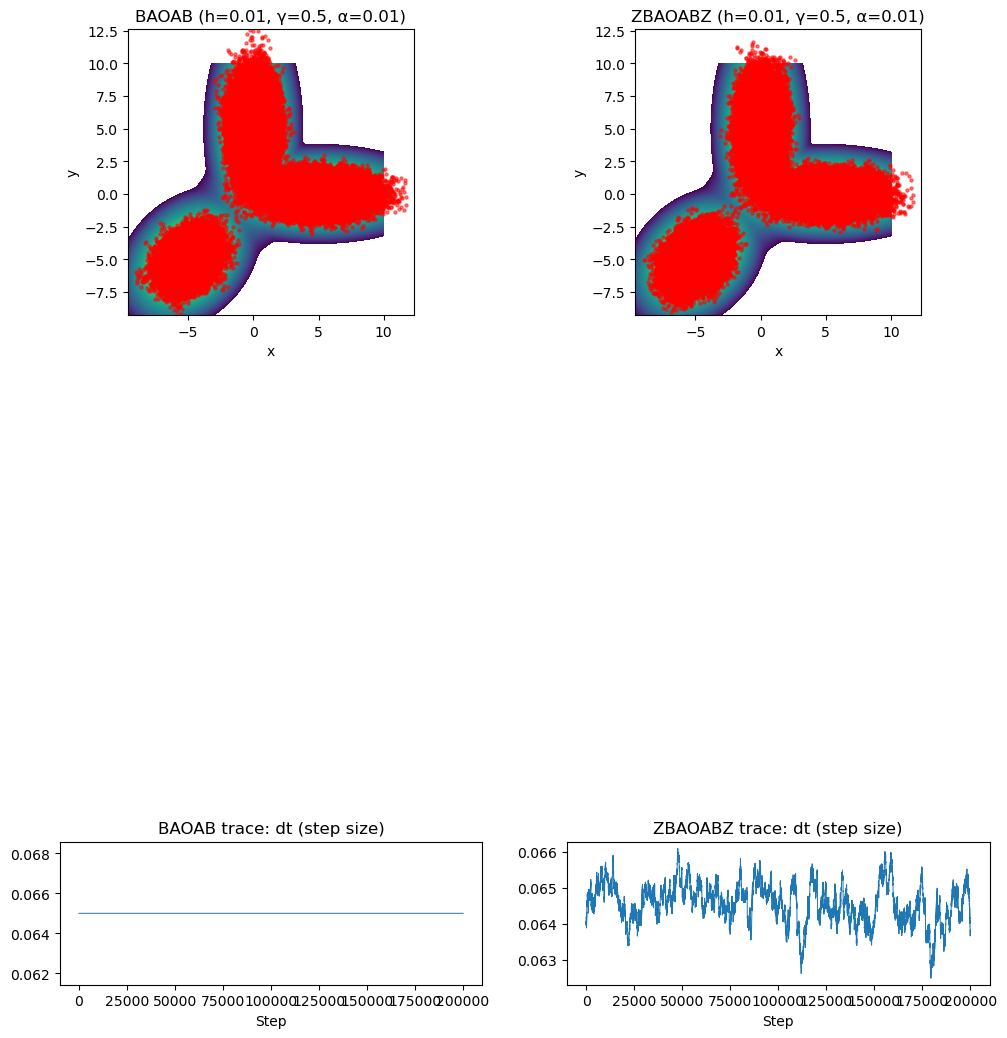

In [2]:
import numpy as np
from numba import njit
from ipywidgets import interact, FloatLogSlider
from viz import plot_samplers
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import fixed

# ====================================================
# 2D Gaussian Mixture Model (GMM)
# ====================================================

# Define mixture components
weights = np.array([0.4, 0.3, 0.3])  # mixture weights (sum to 1)
means = np.array([
    [-5.0, -5.0],   # mode 1
    [0.0,  5.0],    # mode 2
    [5.0,  0.0]     # mode 3
])
covs = np.array([
    [[1.0, 0.3], [0.3, 1.0]],    # slightly correlated
    [[0.5, 0.0], [0.0, 3.0]],    # tall in x-direction
    [[3.0, 0.0], [0.0, 0.5]]     # wide in y-direction
])
inv_covs = np.linalg.inv(covs)
det_covs = np.array([np.linalg.det(c) for c in covs])

# ====================================================
# Gradient of potential energy U = -log p
# ====================================================
@njit
def grad_U(z):
    y, x = z
    p_total = 0.0
    grad_total = np.zeros(2)

    # --- Component 1 ---
    w1 = 0.4
    mu1y, mu1x = -5.0, -5.0
    inv1 = np.array([[1.0989, -0.3297],
                     [-0.3297, 1.0989]])  # precomputed inv([[1.0,0.3],[0.3,1.0]])
    det1 = 0.91
    diff1 = np.array([y - mu1y, x - mu1x])
    e1 = np.exp(-0.5 * diff1 @ inv1 @ diff1)
    coef1 = w1 * e1 / np.sqrt((2*np.pi)**2 * det1)
    p_total += coef1
    grad_total += coef1 * (inv1 @ diff1)

    # --- Component 2 ---
    w2 = 0.3
    mu2y, mu2x = 0.0, 5.0
    inv2 = np.array([[2.0, 0.0],
                     [0.0, 1/3.0]])  # inv([[0.5,0],[0,3]])
    det2 = 1.5
    diff2 = np.array([y - mu2y, x - mu2x])
    e2 = np.exp(-0.5 * diff2 @ inv2 @ diff2)
    coef2 = w2 * e2 / np.sqrt((2*np.pi)**2 * det2)
    p_total += coef2
    grad_total += coef2 * (inv2 @ diff2)

    # --- Component 3 ---
    w3 = 0.3
    mu3y, mu3x = 5.0, 0.0
    inv3 = np.array([[1/3.0, 0.0],
                     [0.0, 2.0]])  # inv([[3,0],[0,0.5]])
    det3 = 1.5
    diff3 = np.array([y - mu3y, x - mu3x])
    e3 = np.exp(-0.5 * diff3 @ inv3 @ diff3)
    coef3 = w3 * e3 / np.sqrt((2*np.pi)**2 * det3)
    p_total += coef3
    grad_total += coef3 * (inv3 @ diff3)

    gradU = grad_total / max(p_total, 1e-12)
    return gradU

# ====================================================
# Log target density (for contours)
# ====================================================
def log_p(y, x):
    pts = np.stack([y, x], axis=-1)
    log_probs = np.zeros(pts.shape[:-1])
    for k in range(len(weights)):
        diff = pts - means[k]
        inv_cov = inv_covs[k]
        det_cov = det_covs[k]
        exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=-1)
        log_probs += weights[k] * np.exp(exponent) / np.sqrt((2*np.pi)**2 * det_cov)
    return np.log(log_probs + 1e-16)

# ====================================================
# Plot setup
# ====================================================
xs = np.linspace(-10, 10, 400)
ys = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(xs, ys)
LOGZ = log_p(Y, X)
vmax, vmin = LOGZ.max(), LOGZ.max() - 15
levels = np.linspace(vmin, vmax, 50)

# sampler parameters
m, M, r, s = 0.5, 50, 0.25, 2
b = 6.5  # BAOAB stepsize multiplier
burnin = int(1e5)
nsteps = int(1e6)  # start smaller for debugging

# ====================================================
# Run and visualize
# ====================================================
plot_samplers(
    alpha=0.01,
    h=0.01,
    gamma=0.5,
    beta=1.0,
    grad_U=grad_U,
    X=X,
    Y=Y,
    LOGZ=LOGZ,
    levels=levels,
    m=m,
    M=M,
    r=r,
    s=s,
    b=b,
    burnin=burnin,
    nsteps=nsteps,
    record_trace=True,
    plot_stride=5)
